This is based on Francesca's picktime and grid search code - see her github for alt version

In [2]:
import yaml
import csv
import eqcorrscan
from eqcorrscan import Tribe
import obspy
from obspy import UTCDateTime, Trace
import pandas as pd
from glob import glob
import numpy as np
from obspy.signal.cross_correlation import *
import matplotlib.pyplot as plt
from geopy import distance

Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


### Find Picktimes

read config file for parameters

In [3]:
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']

vv = config['vv']

Read REDpy Catalogs and Volcano Metadata File

In [4]:
Baker = pd.read_csv(readdir+'Baker_catalog.csv')
Hood = pd.read_csv(readdir+'Hood_catalog.csv')


St_Helens = pd.read_csv(readdir+'MountStHelens_catalog.csv')

# Combining borehole and local catalogs with St_Helens

Helens_Borehole = pd.read_csv(readdir+'MSHborehole_catalog.csv')
Helens_Borehole['Clustered'] += 2000 
# Cluster 0 in Helens_Borehole is now Cluster 2000 in St_Helens
Helens_Local = pd.read_csv(readdir+'MSHlocal_catalog.csv')
Helens_Local['Clustered'] += 3000
# Cluster 0 in Helens_Local is now Cluster 3000 in St_Helens

# Use St_Helens to access all three St Helens catalogs
St_Helens = pd.concat([St_Helens,Helens_Borehole,Helens_Local])

Newberry = pd.read_csv(readdir+'Newberry_catalog.csv')
Rainier = pd.read_csv(readdir+'Rainier_catalog.csv')

volc_md = pd.read_csv(readdir+'Volcano_Metadata.csv')
# read metadata file to create dataframe of labels

Associate networks and stations

In [5]:
volc_md['netsta'] = volc_md['Network'].astype(str)+'.'+volc_md['Station'].astype(str)

Create Lists of Stations for Each Volcano Using volc_md

In [6]:
Baker_sta = volc_md[volc_md['Volcano_Name'] == 'Baker']['netsta'].values.tolist()
Hood_sta = volc_md[volc_md['Volcano_Name'] == 'Hood']['netsta'].values.tolist() 
St_Helens_sta = volc_md[volc_md['Volcano_Name'] == 'St_Helens']['netsta'].values.tolist()
Newberry_sta = volc_md[volc_md['Volcano_Name'] == 'Newberry']['netsta'].values.tolist() 
Rainier_sta = volc_md[volc_md['Volcano_Name'] == 'Rainier']['netsta'].values.tolist()

Create Lists of Volcano Information

In [7]:
volc_list = [Baker,Hood,Newberry,Rainier,St_Helens] # list of dataframes for each volcano
volc_list_names = ['Baker','Hood','Newberry','Rainier','St_Helens'] # list of names of each volcano
volc_sta = [Baker_sta,Hood_sta,Newberry_sta,Rainier_sta,St_Helens_sta] # lists of stations connected to respective volcanoes

Define pick_time

In [8]:
def pick_time(ref_env, data_env_dict, st): 
    est_picktimes=str(st[0].stats.starttime)
    xcor = correlate(data_env_dict,ref_env,int(50*fs))
    index = np.argmax(xcor)
    cc = round(xcor[index],9) #correlation coefficient
    shift = 50*fs-index #how much it is shifted from the reference envelope
    #print(shift, cc, key)
    relative_p = shift/fs
    p = UTCDateTime(est_picktimes) + shift/fs  # p is the new phase pick for each station
    return p, shift, relative_p
def get_cmap(n, name='viridis'): #hsv
#     Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.
    return plt.cm.get_cmap(name, n)

Define location

In [138]:
# define function to predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# define function to compute residual sum of squares
def error(synth_arrivals,arrivals):
    res = arrivals - synth_arrivals   #make sure arrivals are in the right order, maybe iterate through keys
    res_sqr = res**2
    rss = np.sum(res_sqr)
    return rss

# define function to iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)):
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                synth_arrivals = []
                for h in range(len(sta_x)):
                    tt = travel_time(t0[i],x_vect[j],y_vect[k],vs,sta_x[h],sta_y[h])
                    synth_arrivals.append(tt)
                rss = error(np.array(synth_arrivals),np.array(arrivals))
                rss_mat[i,j,k] = rss
    return rss_mat

Find picktimes and location

cluster: 13
13 offsets are {'vdbehzrpba013': 0.0, 'mbwehzrpba013': 10.65, 'passhhzrpba013': 2.975, 'shukbhzrpba013': 7.2}


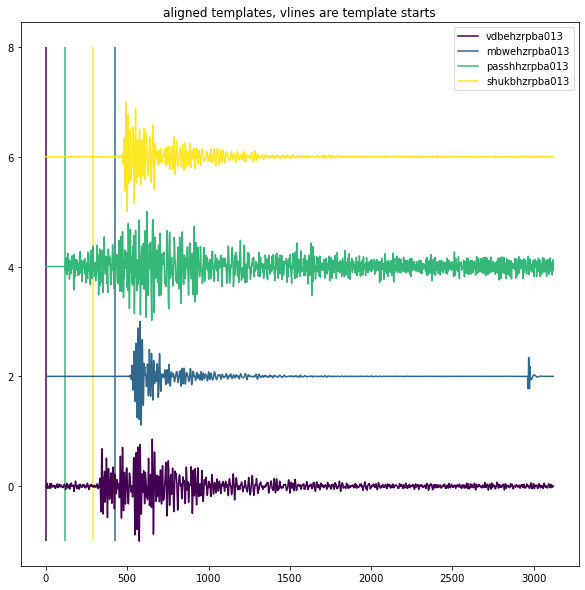

In [9]:
# for vv,v in enumerate(volc_sta): #vv is the number in the list, v is the station list for current volcano
v = volc_sta[vv]
clid = volc_list[vv]['Clustered'].values.tolist() #find the largest cluster ID for a volcano to set range
#make csv?
for cl in range(13,14):#np.unique(clid): #normally range(0,clid[-1]) #for each cluster
    temps_s = {} #empty dictionary that will be filled with the templates for this cluster
    #indexes are the same
    print("cluster:",cl)
    for s in range(0,len(v)): #loop through stations
        net, sta =  v[s].split('.') #add specific network per station
#         print(f'Volcano_{volc_list_names[vv]}_Network_{net}_Station_{sta}')
#         try: 
        # try to read the .tgz file and get the template for this cluster
        T = Tribe().read(*glob(f'{homedir}templates/Volcano_{volc_list_names[vv]}_Network_{net}_Station_{sta}_Channel_*.tgz'))
        for t in T: #for each template in the Tribe
            if t.name.endswith(str(cl).zfill(len(str(cl)))): #if the template name endswith this cluster
                temps_s[t.name]=t #save to dictionary
                break
#         except:
#             print(f'Either .tgz does not exist or cl {str(cl).zfill(len(str(zf)))} does not have a template')
#             pass
    if len(temps_s) < minsta:
        continue
    data_env_dict = {}
    for t in temps_s: #for each saved template (aka each template for this cluster and volc that exists)
        data_envelope = obspy.signal.filter.envelope(temps_s[t].st[0].data) #make an envelope
        data_envelope /= np.max(data_envelope) #average envelope (?)
        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length) #smooth the envelope
        data_env_dict[temps_s[t].name] = data_envelope #save the envelope
        
    pick_times = {} #dictionary of picktimes for each template
    for key in data_env_dict: #for each envelope
        p, shift, relative_p = pick_time(ref_env=data_env_dict[list(data_env_dict.keys())[0]], 
                data_env_dict=data_env_dict[key],st=temps_s[key].st) #calculate picktimes
        pick_times[key] = relative_p #save to dictionary
    print(f'{cl} offsets are {pick_times}')
    
    #arranging picktimes (largest number is earliest, so want diff between largest and everything else)
    #will NOT be used for plotting, but will be used for location
    dif_dict = {} #dictionary of picktimes in reference to earliest picktime (in positive seconds after the earliest picktime)
    max_value = max(pick_times, key=pick_times.get) #get key for max value of pick_times aka the earliest picktime
    for key in pick_times: #for each picktime
        dif = round(abs(pick_times[max_value] - pick_times[key]),4) #max value minus current value
        dif_dict[key] = dif #save to dictionary

    
    #plotting picktimes and offsets
    cmap = get_cmap(len(temps_s)) #get cmap aka colors for the plot, see def(get_cmap) for color palette
    plt.figure(figsize=(10,10)) #set plot size
    plt.title('aligned templates, vlines are template starts') #plot title
    for tt,t in enumerate(temps_s): #for every template
        shift = round(pick_times[t]*fs) #find shift based on picktimes
        st0 = temps_s[t].st.copy() #make a copy for a reference
        maxdata = len(temps_s[t].st[0].data[:]) #find maximum length of template stream

        empty = Trace(np.zeros(shift)) #an empty trace/a trace filled with zeros
        if shift<0: #if shift is negative
            temps_s[t].st[0].data[:shift]=st0[0].data[-shift:] #shift to the left
        if shift>0: #if shift is positive
            temps_s[t].st[0].data[shift:]=st0[0].data[:-shift] #shift to the right
            temps_s[t].st[0].data[:shift]=empty.data[:shift] #get rid of leftover data from shift
        #note: if shift == 0, will be plotting with no shifting
        plt.plot(temps_s[t].st[0].data[:]/np.max(np.abs(temps_s[t].st[0].data[:]))+2*tt,color=cmap(tt), label=t) #plot stream
        plt.vlines(shift,ymin=-1,ymax=2*len(temps_s),color=cmap(tt)) #plot line in same color representing the start of the template
        plt.legend() #show the legend
    
#     first_sta = max(pick_times, key=pick_times.get) #gives you the template name for the first
    #station to get a signal (largest/most positive pick time)
    
    # location
    # define input parameters
    arrivals = [] #relative picktimes
    sta_lats = [] #station latitudes
    sta_lons = [] #station longitudes
    for key in dif_dict:
        arrivals.append(dif_dict[key])
        ##########################
        #figure out how to select specific station from template name (remember PIN vs PINE and CC STD vs UW STD)
        ##########################
        sta_lats.append()
        #station lats - read volc md for those, .startswith(), separate by number of characters 
        #(so a PIN tmeplate doesn't also trigger a PINE template for example)
        #or possibly a if template[:3]==station.lower()[:]: instead because that's specific to the number of letters
        #possible issue with PIN and PINE if pinehz... and pineehz... both start with "pine"
    vs = 1000


    # define grid origin in lat,lon and grid dimensions in m
    lat_start = 48.6
    lon_start = -122.2
    grid_length = 7e4 #in meters
    grid_height = 7e4
    step = 1000
    t_step = 1

    #automate picktimes
    #add loop for volcano/station
    picks = pd.read_csv(homedir+f'/templates/pick_times/{volc_list_names[vv]}_pick_times.csv')
    arrivals = picks[picks['Cluster_ID']==cl]['Pick_Time'].values.tolist() #or possibly some loop for creating a 
    #dictionary instead of a list, where each station equals a Pick_Time, 1 dictionary per cluster per volcano




    sta_x = []
    sta_y = []
    for i in range(len(sta_lats)):
        x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
        y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
        sta_x.append(x_dist)
        sta_y.append(y_dist)

    # set grid points
    x_vect = np.arange(0, grid_length, step)
    y_vect = np.arange(0, grid_height, step)
    t0 = np.arange(0,np.max(arrivals),t_step)

    # carry out the gridsearch
    rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals)

    # find lowest error lat, lon, and origin time
    loc_idx = np.unravel_index(np.argmin(rss_mat), rss_mat.shape)

    # plot a spatial map of error for lowest-error origin time
    fig,ax = plt.subplots()
    ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
    im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,grid_length,0,grid_height])
    fig.colorbar(im)
    plt.show()
    
    #write into csv relative picktimes in seconds after first_sta, probably list separated by 
    #spaces, like how stations are saved in events, make sure index is same for the template 
    #name and picktime

### Grid Search

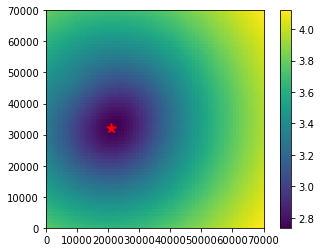

In [141]:
# define input parameters
arrivals = [10.65, 0, 7.675, 3.45] #relative picktimes? idk how it handling a zero for a picktime would work
sta_lats = [49.0261,48.78407,48.998299,48.85284] #station lats - read volc md for those, .startswith(), separate by number of characters 
#(so a PIN tmeplate doesn't also trigger a PINE template for example)
#or possibly a if template[:3]==station.lower()[:]: instead because that's specific to the number of letters
#possible issue with PIN and PINE if pinehz... and pineehz... both start with "pine"
sta_lons = [-122.1028,-121.90145,-122.085197,-121.67695] #station lons
vs = 1000


# define grid origin in lat,lon and grid dimensions in m
lat_start = 48.6
lon_start = -122.2
grid_length = 7e4 #in meters
grid_height = 7e4
step = 1000
t_step = 1

#automate picktimes
#add loop for volcano/station
picks = pd.read_csv(homedir+f'/templates/pick_times/{volc_list_names[vv]}_pick_times.csv')
arrivals = picks[picks['Cluster_ID']==cl]['Pick_Time'].values.tolist() #or possibly some loop for creating a 
#dictionary instead of a list, where each station equals a Pick_Time, 1 dictionary per cluster per volcano




sta_x = []
sta_y = []
for i in range(len(sta_lats)):
    x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
    y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
    sta_x.append(x_dist)
    sta_y.append(y_dist)

# set grid points
x_vect = np.arange(0, grid_length, step)
y_vect = np.arange(0, grid_height, step)
t0 = np.arange(0,np.max(arrivals),t_step)

# carry out the gridsearch
rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals)

# find lowest error lat, lon, and origin time
loc_idx = np.unravel_index(np.argmin(rss_mat), rss_mat.shape)

# plot a spatial map of error for lowest-error origin time
fig,ax = plt.subplots()
ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,grid_length,0,grid_height])
fig.colorbar(im)
plt.show()